# Lending Club Data Set Prediction

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import t
from numpy.random import seed
from scipy.stats import norm
from scipy.stats import ttest_ind_from_stats
df= pd.read_csv('/Users/ankit/Desktop/Springboard dox/Python/LoanStats3a_securev1_new.csv',low_memory=False)


# Understanding the various features (columns) of the dataset


In [ ]:
print(df.info())
df.head()
df.columns

In [106]:
print(df.shape)

(42542, 61)


In [ ]:
#Drop columns with data NaN

In [ ]:
#df=df.dropna(axis=1)

In [ ]:
#df.shape

In [ ]:
df.head()

# Data Wrangling

In [ ]:
#rename the column names

df = df.rename(columns={"loan_amnt": "loan_amount", "funded_amnt": "funded_amount", "funded_amnt_inv": "investor_funds",
                       "int_rate": "interest_rate", "annual_inc": "annual_income"})


In [ ]:
df.head()
print(type(df['interest_rate'][0]))

In [ ]:
#removing percentage sign from the interest_rate
df.interest_rate = df.interest_rate.str.replace('%', '').astype('float64')
print(df.interest_rate.head())

In [ ]:
#remove months from term colums
df.term = df.term.str.replace('months', '')
df.term.head()

In [ ]:
#selecting unique column as index

df['id'].is_unique

In [ ]:
df.set_index('id')
df.drop(['member_id'],axis=1,inplace=True)

In [ ]:
missing_fractions = df.isnull().mean().sort_values(ascending=False)
missing_fractions.head(20)

In [ ]:
plt.figure(figsize=(6,3), dpi=90)
missing_fractions.plot.hist(bins=20)
plt.title('Histogram of Feature Incompleteness')
plt.xlabel('Fraction of data missing')
plt.ylabel('Feature count')

From the above histogram, we see there's a large gap between features missing "some" data (<20%) and those missing "lots" of data (>40%). Because it's generally very difficult to accurately impute data with more than 30% missing values, we drop such columns. First store all variables missing more than 30% data in an alphabetical list:

In [ ]:
drop_list = sorted(list(missing_fractions[missing_fractions > 0.3].index))
print(len(drop_list))
df.drop(labels=drop_list, axis=1, inplace=True)
df.shape

So now we dropped the columns with more than 30% missing values.

In [ ]:
print(df.columns)
df.info()

In [ ]:
df['emp_title'].describe()



There are too many different job titles for this feature to be useful, so we drop it.




In [ ]:
df.drop(labels='emp_title', axis=1, inplace=True)

In [ ]:
df['emp_length'].value_counts(dropna=False).sort_index()

In [ ]:
df['emp_length'].replace(to_replace='10+ years', value='10 years', inplace=True)
df['emp_length'].replace('< 1 year', '0 years', inplace=True)

In [ ]:
def emp_length_to_int(s):
    if pd.isnull(s):
        return s
    else:
        return np.int8(s.split()[0])
df['emp_length'] = df['emp_length'].apply(emp_length_to_int)
df['emp_length'].value_counts(dropna=False).sort_index()

Annual income ranges from \$0 to \$9,550,000, with a median of \$65,000. Because of the large range of incomes, we should take a log transform of the annual income variable.


In [ ]:

df['log_annual_inc'] = df['annual_income'].apply(lambda x: np.log10(x+1))
df['log_annual_inc'].describe()

In [ ]:
df.corr()

In [ ]:
df["loan_status"].value_counts()


In [ ]:
# Determining the loans that are bad from loan_status column

bad_loan = ["Charged Off", "Default", "Does not meet the credit policy. Status:Charged Off", "In Grace Period", 
            "Late (16-30 days)", "Late (31-120 days)"]


df['loan_condition'] = np.nan

def loan_condition(status):
    if status in bad_loan:
        return 'Bad Loan'
    else:
        return 'Good Loan'
    
    
df['loan_condition'] = df['loan_status'].apply(loan_condition)

# Pie Chart for Loan Conditions

In [ ]:
#f, ax = plt.subplots(1,2, figsize=(16,8))

labels ="Good Loans", "Bad Loans"

plt.suptitle('Information on Loan Conditions', fontsize=15)

df["loan_condition"].value_counts().plot.pie(explode=[0,0.10],autopct='%1.0f%%', shadow=True,labels=labels, fontsize=12, startangle=90)




In [ ]:
df['income_category'] = np.nan
lst = [df]

for col in lst:
    col.loc[col['annual_income'] <= 100000, 'income_category'] = 'Low'
    col.loc[(col['annual_income'] > 100000) & (col['annual_income'] <= 200000), 'income_category'] = 'Medium'
    col.loc[col['annual_income'] > 200000, 'income_category'] = 'High'

In [ ]:
# Let's transform the column loan_condition into integrers.

lst = [df]
df['loan_condition_int'] = np.nan

for col in lst:
    col.loc[df['loan_condition'] == 'Good Loan', 'loan_condition_int'] = 0 # Negative (Bad Loan)
    col.loc[df['loan_condition'] == 'Bad Loan', 'loan_condition_int'] = 1 # Positive (Good Loan)
    
# Convert from float to int the column (This is our label)  
df['loan_condition_int'] = df['loan_condition_int'].astype(int)
fig, (ax1, ax2)= plt.subplots(nrows=1, ncols=2, figsize=(14,6))

# Change the Palette types tomorrow!

sns.violinplot(x="income_category", y="loan_amount", data=df, palette="Set2", ax=ax1 )
sns.violinplot(x="income_category", y="loan_condition_int", data=df, palette="Set2", ax=ax2)


In [ ]:
#df.corr(loan_status,annual_income)

# Loan Condition V/s Income

In [ ]:
plt.scatter(df.loan_condition,df.annual_income)
plt.xlabel("condition")
plt.ylabel("income")
plt.ylim(0,1400000)
plt.title("Range of income with respect to loan condition")
plt.show()

# Loan Consition V/s Fico Scores

In [ ]:
sns.violinplot(x="fico_range_high", y="loan_condition", data=df, palette="Set2" )
plt.show()

The mean of the good loans is more than 700 and most of the values of fico_score lies near 700 score hence the fico score for good loans should be closer to 700.

In [ ]:
df.home_ownership.groupby(df.loan_condition).value_counts().plot.bar()
plt.show()

Loan Grades and Subgrades are assigned by Lending Club based on the borrower’s credit worthiness and also on some variables specific to that Loan.

In [ ]:
df.grade.groupby(df.loan_condition).value_counts().plot.bar()
plt.show()

The majority of loans is either graded as B or C — together these correspond to more than 50% of the loan population.
While there is a considerable amount of A graded or “prime” loans (~17%), there is a small amount of E graded, or “uncollectible” loans (~0,06%). Which is a good sign for Lending Club.
But, are these the right grades?

# Statistical Inferences of the Dataset

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(16,5))

loan_amount = df["loan_amount"].values
funded_amount = df["funded_amount"].values
investor_funds = df["investor_funds"].values
sns.distplot(loan_amount, ax=ax[0], color="red")
ax[0].set_title("Loan Applied by the Borrower", fontsize=14)
sns.distplot(funded_amount, ax=ax[1], color="blue")
ax[1].set_title("Amount Funded by the Lender", fontsize=14)
sns.distplot(investor_funds, ax=ax[2], color="green")
ax[2].set_title("Total committed by Investors", fontsize=14)

In [ ]:
df.boxplot(column='loan_amount')


In [ ]:
mean =np.mean(df.funded_amount)
std =np.std(df.funded_amount)
print(mean)
print(std)

# Null hypothesis: The mean interest rates offered for A grade loans are less than the other grades.

In [ ]:
df.interest_rate.groupby(df.grade).value_counts().plot.bar()
plt.show()


In [ ]:
sns.distplot(df.interest_rate[df.grade!='A'].astype('float64').values,color="red")


In [ ]:
def loan_sampler_A(n):
    return np.random.choice(df.interest_rate[df.grade=='A'].astype('float64'), n)
def loan_sampler_other(n):
    return np.random.choice(df.interest_rate[df.grade!='A'].astype('float64'),n)

In [ ]:
seed(47)
size=50
sample1 = loan_sampler_A(size).astype('float64')
sample2 = loan_sampler_other(size).astype('float64')
print(sample1)
type(sample1[0])

In [ ]:
mean_A = np.mean(sample1)
mean_other = np.mean(sample2)
std_A=np.std(sample1)
std_other=np.std(sample2)
seed(47)
N=500
# take your samples here
total_mean_A=np.empty(N)
total_mean_other=np.empty(N)
for i in range (N):
    total_mean_A[i]=np.mean(loan_sampler_A(size))
    total_mean_other[i]=np.mean(loan_sampler_other(size))


In [ ]:
n=len(total_mean_A)
x=np.sort(total_mean_A)
y=np.arange(1,n+1)/n
plt.plot(x,y,marker='.',linestyle='none')
# Label the axes
plt.xlabel('Interest rate for Grade A Loans')
plt.ylabel('ECDF')
plt.show()

In [ ]:
n=len(total_mean_other)
x=np.sort(total_mean_other)
y=np.arange(1,n+1)/n
plt.plot(x,y,marker='.',linestyle='none')
# Label the axes
plt.xlabel('Interest rate for Other Grade Loans')
plt.ylabel('ECDF')
plt.show()

It is very much clear from the above ECDF graph that the interest rates for the other grades lies in the range of (12.5,15)

In [ ]:
from scipy import stats
import scipy.stats
print(stats.ttest_ind(total_mean_other,total_mean_A))

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h
print("The confidence interval for A grade loans is: "+str(mean_confidence_interval(total_mean_A)))
print("The confidence interval for all other loan other than A grade loans is:"+ str(mean_confidence_interval(total_mean_other)))
           
      

Here, the p value is less than 0.05 hence the result is of high significance.

In [ ]:
df.verification_status.groupby(df.loan_condition).value_counts().plot.bar()
plt.show()


The observation is quite unexpected as it was expected that people with verified status should have less charged off loans but it is the opposit. Hence,verification status does not give any clear idea of the impact on the loan condition. So we try to see in other way.


In [ ]:
pd.crosstab(df ['verification_status'], df ['loan_condition'], margins=True)


This shows that 41.3% of the bad loans were not verified.

In [ ]:
df[['fico_range_low', 'fico_range_high']].describe()


In [ ]:
df.grade.groupby(df.loan_condition).value_counts().plot.bar()
plt.show()

Number of bad loans were less in the category A jobs and it had more number of good loans as compared to the other category.

# Correlation among the features

Few important columns are selected from the full dataset based on the significance and the data present prior to the approval of the loan. The columns are saved in 'imp_columns' list.

Now we will see the correlation between the numerical data

In [ ]:
imp_columns=['loan_amount','term','interest_rate','grade','emp_length','home_ownership','annual_income','verification_status','loan_status','loan_condition','purpose','title','addr_state','fico_range_low','fico_range_high','income_category']
df2=df[imp_columns]
df2.corr()

employee length,annual income and fico scores have strong positive correlation with the loan amount .

In [ ]:
df[imp_columns].head()

Correlation between all the important columns:

In [ ]:
df2.apply(lambda x: x.factorize()[0]).corr()
corr_imp=df2.apply(lambda x: x.factorize()[0]).corr()


In [ ]:
import seaborn as sns

sns.heatmap(corr_imp, 
        xticklabels=corr_imp.columns,
        yticklabels=corr_imp.columns)

# Data Preparation for Model Building

In [ ]:
# Convert all non-numeric values to number
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
for var in df.columns:
    le = LabelEncoder()
    df[var]=df[var].astype('str')
    df[var]=le.fit_transform(df[var])
df[imp_columns].dtypes


# Model building

In [ ]:
from sklearn import preprocessing
target_name='loan_condition'
y= df.loan_condition
X= df.drop(target_name,axis=1)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=123)
from sklearn import neighbors
knn = neighbors.KNeighborsClassifier(n_neighbors=5)

In [ ]:
knn.fit(X_train, y_train)

In [ ]:
y_predict=knn.predict(X_test)
#y_predict=y_predict.reshape(-1,1)

In [111]:
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_predict))

Accuracy: 0.9310831139526138


We got an accuracy of 0.93 . As our model has good loans dominating the sample we may need to over sample our data with bad sample.

We would now check the effect on the accuracy by changing n in the model and the graph is plotted below:

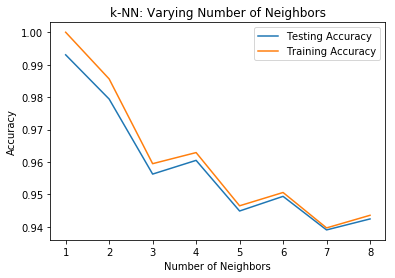

In [112]:
neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))
from sklearn.neighbors import KNeighborsClassifier
# Loop over different values of k
for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fit the classifier to the training data
    knn.fit(X_train,y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test, y_test)

# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()


From the above graph we can see that we get best result at n= 4 which gives us training accuracy as 0.96 and testing accuracy as 0.94

# Confusion Matrix

In [ ]:
#Random Forest
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 10000, random_state = 42)
rf.fit(X_train, y_train);
predictions = rf.predict(X_test)
cm = confusion_matrix(y_test,predictions)
print(cm)

#Decision Tree

from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
cm2 = confusion_matrix(y_test,predictions)
print(cm2)

Imbalanced datasets can be seen everywhere. Usually banks want to predict fraudulent credit card charges but only a small fraction of observations are actually positives. I’d guess that only 1 in 10,000 credit card charges are fraudulent, at most. Recently, oversampling the minority class observations has become a common approach to improve the quality of predictive modeling. By oversampling, models are sometimes better able to learn patterns that differentiate classes.

In [ ]:
!pip install imblearn


In [103]:
from imblearn.over_sampling import SMOTE


In [107]:
x_train, x_val, yy_train, y_val = train_test_split(X_train, y_train,
                                                  test_size = .1,
                                                  random_state=12)
sm = SMOTE(random_state=12, ratio = 1.0)
x_train_res, y_train_res = sm.fit_sample(x_train, yy_train)

In [110]:
clf_rf = RandomForestClassifier(n_estimators=25, random_state=12)
clf_rf.fit(x_train_res, y_train_res)
print ('Validation Results')
print( clf_rf.score(x_val, y_val))
print (recall_score(y_val, clf_rf.predict(x_val)))
print (clf_rf.score(X_test, y_test))
print (recall_score(y_test, clf_rf.predict(X_test)))

Validation Results
1.0
1.0
1.0
1.0
